# Vision AI Segmentation Demo

## Overview
This colab demonstrates how to use the the Segmentation API on Vision AI. Using the steps below, you can generate masks using either the semantic segmentation or background segmentation models. This demo also demonstrates how to use a generated mask to extract a transparent image without a background.

## Setup





In [ ]:

# @title 1. Import libraries and initialize Vertex SDK
# Addtional authentication is required for Google Colab
import requests
import json
import io
import base64
import sys
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth
    auth.authenticate_user()

from IPython.display import display
from PIL import Image
from google.auth import default
from google.cloud import storage
from google.auth.transport.requests import Request
from google.cloud import aiplatform

# @markdown Enter your Google Cloud project ID and set a location.
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
aiplatform.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
# @title 2. Define helper functions
def download_image_from_gcs(file_path):
  if(file_path == ''):
    print("Enter a valid path to an image file in the GCS_URI field above.")
    return
  client = storage.Client()
  bucket_name, file_name = file_path.replace('gs://', '').split("/", 1)
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_name)
  image_bytes = blob.download_as_bytes()
  img = Image.open(io.BytesIO(image_bytes))
  display(img)
  return image_bytes

def call_segmentation_api(url, request_payload):
  credentials, _ = default()
  credentials.refresh(Request())
  headers = {
      "Authorization": f"Bearer {credentials.token}",
      "Content-Type": "application/json; charset=utf-8"
    }

  response = requests.post(url, headers=headers, data=json.dumps(request_payload))
  if response.status_code == 200:
    return response
  else:
    print("Request failed with status code:", response.status_code)
    print(response.json())

def parse_background_segment_response(response):
  data = response.json()
  foreground_score = data.get('modelOutputs').get('backgroundsegment@001').get('annotation').get('foregroundScore')  # Get the 'foreground_score' field
  background_score = data.get('modelOutputs').get('backgroundsegment@001').get('annotation').get('backgroundScore')  # Get the 'background_score' field
  mask_string = data.get('modelOutputs').get('backgroundsegment@001').get('annotation').get('mask')  # Get the 'mask' field
  print('Foreground confidence score: ' + str(foreground_score))
  print('Background confidence score: ' + str(background_score))
  mask_decoded_bytes = base64.b64decode(mask_string)
  mask = Image.open(BytesIO(mask_decoded_bytes)).convert('L')
  return mask

def get_background_segmentation_mask(image_bytes, invert_mask):
  from PIL import ImageOps
  encoded_image_bytes = base64.b64encode(image_bytes).decode('utf-8')
  url = f'https://visionai.googleapis.com/v1alpha1/projects/{PROJECT_ID}/locations/{LOCATION}/applications/prebuilt/instances/backgroundsegment@001:predict'
  request_payload = {
      "inputs": {
        "input": {
          "image": {
              "image_bytes": encoded_image_bytes
          }
        }
      }
  }

  response = call_segmentation_api(url, request_payload)
  mask = parse_background_segment_response(response)

  if(invert_mask):
    return ImageOps.invert(mask)
  else:
    return mask

def get_semantic_segmentation_mask(image_bytes, class_id):
  encoded_image_bytes = base64.b64encode(image_bytes).decode('utf-8')
  url = f'https://visionai.googleapis.com/v1alpha1/projects/{PROJECT_ID}/locations/{LOCATION}/applications/prebuilt/instances/semanticsegment@001:predict'
  request_payload = {
      "inputs": {
        "input": {
          "image": {
              "image_bytes": encoded_image_bytes
          }
        }
      },
      "processor_configs": {
          "semanticsegment@001": {
              "semantic_segment_config": {
                  "segmentation_classes": f"{class_id}"
              }
          }
      }
  }

  response = call_segmentation_api(url, request_payload)
  mask = parse_semantic_segment_response(response)
  return mask

def parse_semantic_segment_response(response):
  data = response.json()
  mask_string = data.get('modelOutputs').get('semanticsegment@001').get('annotation').get('mergedMask')
  mask_decoded_bytes = base64.b64decode(mask_string)
  mask_image = Image.open(BytesIO(mask_decoded_bytes)).convert('L')
  return mask_image

def generate_transparent_image(image_bytes, image_mask):
  """Generates a transparent image from an original image and a mask"""
  input_image = Image.open(BytesIO(image_bytes))
  transparent_background = Image.new("RGBA", input_image.size, (0, 0, 0, 0))  # Create transparent background
  transparent_background.paste(input_image, mask=image_mask)  # Paste with mask
  transparent_background.putalpha(image_mask)
  return transparent_background

### 3. Select an image to segment

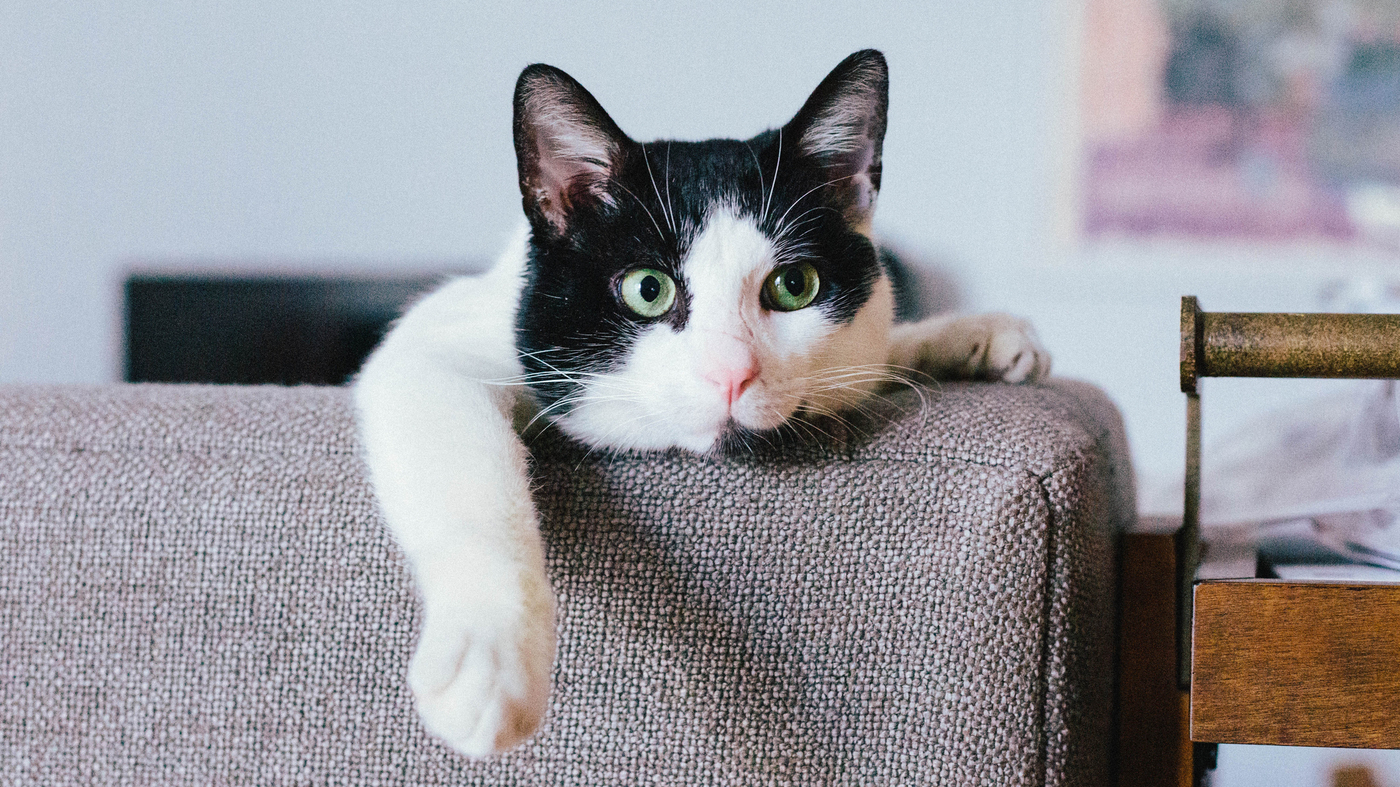

In [ ]:
# @title Get an image from the web
# @markdown Paste the link to a .jpg, .png or .bmp image below and run this cell.
URL = "https://media.npr.org/assets/img/2021/08/11/gettyimages-1279899488_wide-f3860ceb0ef19643c335cb34df3fa1de166e2761-s1400-c100.jpg"  # @param {type:"string"}
# @markdown Run this cell and to set your input image and display it below.

# Import the necessary packages
from PIL import Image
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow
from IPython.display import display

def get_image_from_web(image_path):
  if(URL == ''):
    print('Enter a valid https:// link to an image online in the URL field above.')
  else:
    response = requests.get(image_path)
    image_bytes = response.content
    img = Image.open(BytesIO(response.content))
    display(img)
    return image_bytes

IMAGE_BYTES = get_image_from_web(URL)

Saving cowboygen.png to cowboygen.png
image size(with x height): 389 x 389


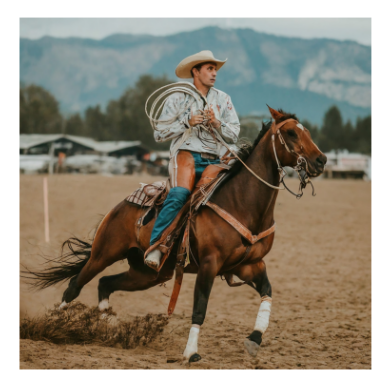

In [ ]:
# @title Upload an image from your computer
# @markdown Run this cell to upload an image from your computer to Colab.

import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

from PIL import Image
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow
from IPython.display import display
# @markdown Your uploaded image will be resized for faster processing.

images = files.upload()
IMAGE_BYTES = list(images.values())[0]
image_pil = Image.open(io.BytesIO(IMAGE_BYTES)).convert("RGB")
image_pil.thumbnail((1024, 1024))
plt.axis("off")
plt.imshow(image_pil)
print(f"image size(with x height): {image_pil.size[0]} x {image_pil.size[1]}")

In [ ]:
# @title Select an image in Google Cloud Storage
# @markdown Paste the gs:// path to an image in you Google Cloud Storage.
GCS_URI = ""  # @param {type:"string"}

# @markdown Run this cell and to set your input image and display it below.

# Import the necessary packages
from PIL import Image
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow
from IPython.display import display

def download_image_from_gcs(file_path):
  if(file_path == ''):
    print("Enter a valid path to an image file in the GCS_URI field above.")
    return
  client = storage.Client()
  bucket_name, file_name = file_path.replace('gs://', '').split("/", 1)
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_name)
  image_bytes = blob.download_as_bytes()
  img = Image.open(io.BytesIO(image_bytes))
  display(img)
  return image_bytes

IMAGE_BYTES = download_image_from_gcs(GCS_URI)

## Generate a mask with Segmentation

Foreground confidence score: 0.80647707
Background confidence score: 0.92530411


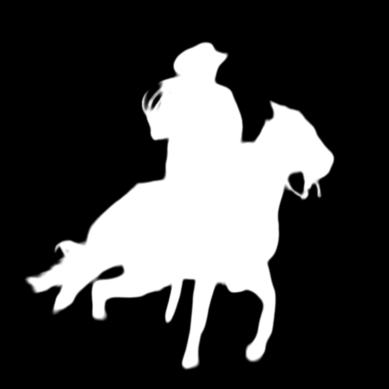

In [ ]:
# @title Get a foreground mask
# @markdown Obtain a mask of the image foreground using the background segment feature.
invert_mask = False
mask = get_background_segmentation_mask(IMAGE_BYTES, invert_mask)
display(mask)

Foreground confidence score: 0.80647707
Background confidence score: 0.92530411


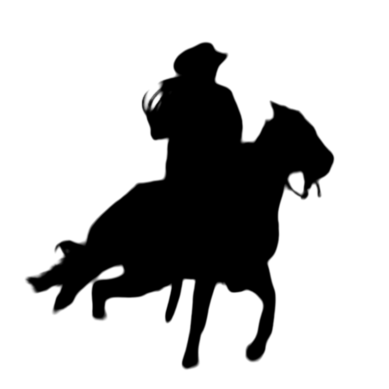

In [ ]:
# @title Get a background mask
# @markdown Obtain a mask of the image background. The foreground mask is inverted to generate the background mask.
invert_mask = True
mask = get_background_segmentation_mask(IMAGE_BYTES, invert_mask)
display(mask)

In [ ]:
# @title Segment a specific class in the image

# @markdown Enter the ID of a valid semantic class to segment.
CLASS_ID = 7 # @param {type:"number"}

# @markdown You can find the full table of semantic classes in the [Segmentation API documentation](https://docs.google.com/document/d/1Ga65vi5La_f3MMLv_Dl-QbCw9qxIKFTyZglOnaHkGOM/edit?resourcekey=0-neTmO_OeaNPL8W_DXdSysg&tab=t.0#heading=h.jl6d3hm26s1l).

get_semantic_segmentation_mask(IMAGE_BYTES, CLASS_ID)

## Removing image backgrounds

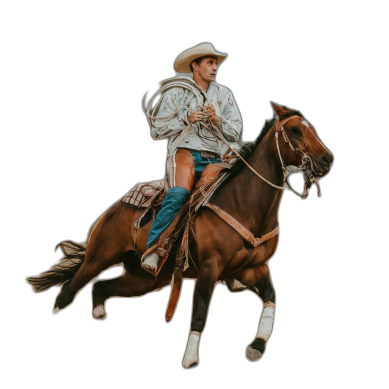

In [ ]:
# @title Generate a transparent image
# Use the mask you generated from the API to make the original image transparent.
transparent_image = generate_transparent_image(IMAGE_BYTES, mask)
display(transparent_image)

In [ ]:
# @title Save your image to GCS
# @markdown Enter a *gs://* path to a directory in your Google Cloud project to download the transparent image.
OUTPUT_GCS_URI = ""  # @param {type:"string"}
if(OUTPUT_GCS_URI.startswith('gs://')):
  OUTPUT_GCS_URI = OUTPUT_GCS_URI.replace('gs://', '')
# @markdown Enter a name to save the image as.
IMAGE_FILE_NAME = ""  # @param {type:"string"}
import io

def save_image_to_gcs(image, destination_blob_path):
  """Saves an image to Google Cloud Storage"""
  dest_bucket, dest_blob_file = destination_blob_path.split("/", 1)

  output_buffer = io.BytesIO()
  image.save(output_buffer, format='PNG')
  output_buffer.seek(0)  # Rewind buffer to the beginning

  client = storage.Client()
  bucket = client.bucket(dest_bucket)
  blob = bucket.blob(dest_blob_file)
  blob.upload_from_file(output_buffer)

destination_path = f'{OUTPUT_GCS_URI}/{IMAGE_FILE_NAME}.png'
save_image_to_gcs(transparent_image, destination_path)

In [ ]:
# @title Bulk remove image backgrounds
# @markdown Use the segmentation API to remove background from a set of images
# @markdown in a GCS directory.

# @markdown Specify the GCS directory to read the images from.
GCS_SOURCE = '' # @param {type:"string"}
# @markdown Specify the GCS directory to upload the edited images to.
GCS_DESTINATION = '' # @param {type:"string"}
# @markdown **[Optional]** Use a prefix filter to specify a set of images in the
# @markdown source directory.
PRODUCT_PREFIX = '' # @param {type:"string"}

def list_images_from_gcs(bucket_name):
  if(bucket_name == ''):
    print("Enter a valid path to an image file in the GCS_URI field above.")
    return
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  image_extensions = ('.jpg', '.jpeg', '.png')
  images = []

  # Specify the prefix to filter by the folder path
  if PRODUCT_PREFIX != '':
    prefix = f"{PRODUCT_PREFIX}/"
    for blob in bucket.list_blobs(prefix=prefix):
      if blob.name.lower().endswith(image_extensions):
        images.append(f"gs://{bucket_name}/{blob.name}")
    return images

  # Perform the operation on all valid file types in the bucket.
  for blob in bucket.list_blobs():
    if blob.name.lower().endswith(image_extensions):
      images.append(f"gs://{bucket_name}/{blob.name}")
  return images

images = list_images_from_gcs(GCS_SOURCE)
print('Done')

for image in images:
  print(f'Starting operation on image {image}')
  image_path = image
  _, ORIGINAL_IMAGE = image_path.split("://", maxsplit=1)
  DESTINATION_IMAGE = image.split("/")[-1].split(".")[0] + ".png"
  image_original = download_image_from_gcs(ORIGINAL_IMAGE)

  invert_mask = False
  image_mask = get_background_segmentation_mask(image_original, invert_mask)
  pasted_image = generate_transparent_image(image_original, image_mask)
  display(pasted_image)
  #Find bounding box of non-transparent pixels
  bbox = pasted_image.getbbox()
  if bbox:
    pasted_image = pasted_image.crop(bbox)

  destination_blob_name = f'{GCS_DESTINATION}/{DESTINATION_IMAGE}'

  save_image_to_gcs(pasted_image, destination_blob_name)
  print(f'Downloaded transparent image as {destination_blob_name}')